In [1]:
#2017/5/8 根據「自由中國SVM作者預測」檔案內容包裝
#2017/5/10 完成部分包裝
#2017/5/12 完成全部包裝，加入路徑規則尋找

#建立基準特徵詞組向量 -> 將清理後的資料建成文本向量 -> 資料平衡 -> 預測模型建立 -> 評估報表產生
#同主題不同作者、同作者不同主題
#作者歸屬常用語言特徵：高頻詞、2-gram、3-gram、標點符號
#本研究提出語言特徵：詞性組合、否定程度組合、情態詞組合

#函式庫引入
import os
import time
import codecs
import itertools
import numpy as np
from sklearn import svm
from collections import OrderedDict,defaultdict,Counter
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#輸入資料

classification_name = ['雷震','殷海光','夏道平','傅正','龍平甫','蔣勻田','朱伴耘','胡適','羅鴻詔']

#建立作者索引，提取各作者文章內容及索引
author_index = []
for index,name in enumerate(classification_name): #建立作者索引
    author_index.append((name,index))
author_index = OrderedDict(author_index) #作者索引排序(依文本數量高到低)

condicate_author_path = "D:\\課業相關\\論文資料\\SVM\\condicate_author\\" #候選作者文本
normal_feature_path = "D:\\課業相關\\論文資料\\SVM\\language_feature\\" #常用特徵
paper_feature_path = "D:\\課業相關\論文資料\\SVM\\language_feature\\三版\\" #論文提出特徵
unknow_author_path = "D:\\課業相關\\論文資料\\SVM\\unknow_author\\" #未知作者文本

In [3]:
#抓取候選文本，並根據特徵轉換成文本向量

#抓取候選文本，回傳文章序列及各文章類別代號
def article_get(condicate_author_path):

    content_list = [] #所有作者文本內容(未處理)
    article_label = [] #各文本label，也就是作者索引

    for file in os.listdir(condicate_author_path):
        with codecs.open(condicate_author_path+file,'rb','utf8') as f:

            if file.split('_')[0] not in classification_name:
                continue

            title = f.readline()
            content = f.readline().strip()

            content_list.append(content)

            article_label.append(author_index[file.split('_')[0]])
        
    return content_list,article_label

#選擇語言特徵，回傳文本向量詞組
def feature_select(feature_file_path):
    
    feature = [] #特徵
    with codecs.open(feature_file_path,'rb','utf8') as f: #抓取基準特徵
        for i in f.readlines():
            if '\ufeff' in i: #去掉開頭BOM
                i = i.replace('\ufeff','')
            if i.strip() != '':
                feature.append(i.strip().split(',')[0])
                
    return feature

#建立文本向量
def article_vector(X_raw,feature,feature_file_name):
    
    bi_pos_combine = ['N+N','N+V','VH+N','D+V','情態詞']
    more_pos_combine = ['否定','程度']
    
    def line_vec(line): #將文章轉換為特徵向量並回傳
        temp_feature = defaultdict(int)
        
        if any(word in feature_file_name for word in bi_pos_combine): #詞性組合
            line = [line[i]+line[i+1] for i in range(len(line)-1)] 
        elif any(word in feature_file_name for word in more_pos_combine): #2~3詞性組合
            line = [line[i]+line[i+1] for i in range(len(line)-1)] + [line[i]+line[i+1]+line[i+2] for i in range(len(line)-2)]
        else: #其他常用語言特徵
            line = [line[i].split('(')[0] for i in range(len(line))]
            
        for i in line:
            if i in feature:
                temp_feature[i] += 1
        
        return temp_feature 
    
    vector_space = np.zeros((len(X_raw),len(feature)),np.float64)
        
    for index,element in enumerate(X_raw): #依序將文章轉換為特徵向量
        line = element.strip().split()
        temp_feature = line_vec(line)

        for i,j in enumerate(feature):
            vector_space[index, i] = round(temp_feature[j] * 1000000 / len(line)) #取相對頻率
            
    return vector_space

def random_balance(X,y):
    return RandomOverSampler(random_state=0).fit_sample(X,y)

In [4]:
#預測模型建立
def predict_model(X,y,test_size,model):

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=0, stratify=y)
    
    kernel = ''
    
    if model == 'RF':
        kernel = RandomForestClassifier(n_jobs=-1, oob_score = True, \
                                        class_weight = 'balanced',min_samples_leaf=3,n_estimators=700,random_state=0)
    elif model == 'SVM':
        kernel = svm.LinearSVC(class_weight='balanced',random_state=0)
    else:
        print ('model error')
        return
    
    start = time.time()
        
    clf = GridSearchCV(kernel, param_grid={}, cv=10) 
    clf.fit(X_train, y_train)

    end = time.time()

    print ('訓練耗費時間：',end-start,'秒')
    print ()
    
    y_true, y_pred = y_test, clf.predict(X_test)
    
    return clf,y_true,y_pred

In [5]:
#結果評估輸出    
def predict_report(y_true, y_pred):    
    
    for name,index in author_index.items():
        print (str(index)+':'+name,end=' ')
    print ()
    print ()
    
    print (classification_report(y_true, y_pred))
    print ('預測準確率：',accuracy_score(y_true, y_pred))
    print ()

#建立混淆矩陣
def predict_confusion_matrix(y_true, y_pred, normal):

    ZF1 = FontProperties(fname='C:\Windows\Fonts\kaiu.ttf', size=14)
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, fontproperties=ZF1)
        plt.yticks(tick_marks, classes, fontproperties=ZF1)

        if normalize:
            #F-1 score
            '''cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm2 = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
            cm3 = np.zeros((cm.shape[0],cm.shape[1]),np.float64)
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                if cm1[i,j]+cm2[i,j] != 0.0:
                    cm3[i,j] = (2*cm1[i,j]*cm2[i,j])/(cm1[i,j]+cm2[i,j])
            cm = cm3'''
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #recall
            #cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] #precision
            #print("Normalized confusion matrix")
        else:
            #print('Confusion matrix, without normalization')
            pass

        #print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, round(cm[i, j],2),
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    plt.figure(figsize=(8, 6))
    
    if normal:
        plot_confusion_matrix(cnf_matrix, classes=classification_name, normalize=True,
                          title='Normalized confusion matrix')
    elif not normal:
        plot_confusion_matrix(cnf_matrix, classes=classification_name,
                          title='Confusion matrix, without normalization')

    plt.show()

In [6]:
#輸出各作者決策樹規則
def set_tree_path(model):
    tree_path = []
    tree_all_path = []

    author_path = defaultdict(dict)
    for i in classification_name:
        author_path[i] = {}

    def get_code(tree, feature_names, target_names,
                 spacer_base="    "):
        """Produce psuedo-code for decision tree.

        Args
        ----
        tree -- scikit-leant DescisionTree.
        feature_names -- list of feature names.
        target_names -- list of target (class) names.
        spacer_base -- used for spacing code (default: "    ").

        Notes
        -----
        based on http://stackoverflow.com/a/30104792.
        """
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node, depth):
            spacer = spacer_base * depth
            if (threshold[node] != -2):
                tree_path.append(features[node]+' <= '+str(threshold[node]))
                if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
                tree_path.pop()
                tree_path.append(features[node]+' > '+str(threshold[node]))
                if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
                tree_path.pop()
            else:
                target = value[node]
                for i, v in zip(np.nonzero(target)[1],target[np.nonzero(target)]):
                    target_name = target_names[i]
                    target_count = int(v)
                    temp = ' & '.join(tree_path)+':'+str(target_name)+" (" + str(target_count) + " examples)"
                    #tree_all_path.append(' and '.join(tree_path)+':'+str(target_name)+" (" + str(target_count) + " examples)")
                    if target_count not in author_path[target_name]:
                        author_path[target_name][target_count] = [temp]
                    else:
                        author_path[target_name][target_count].append(temp)

        recurse(left, right, threshold, features, 0, 0)

    for i in range(len(model.best_estimator_)):
        get_code(model.best_estimator_[i], feature, classification_name)

    for name in author_path: 
        l = sorted([i for i in author_path[name]],reverse=True)
        with codecs.open('C:\\Users\\user\\Desktop\\author_path\\'+name+'.txt','wb','utf8') as g:
            for i in l:
                g.write('#'+str(i)+'\r\n')
                for e in author_path[name][i]:
                    g.write(e+'\r\n')
                g.write('\r\n')

訓練耗費時間： 22.48677134513855 秒

0:雷震 1:殷海光 2:夏道平 3:傅正 4:龍平甫 5:蔣勻田 6:朱伴耘 7:胡適 8:羅鴻詔 

             precision    recall  f1-score   support

          0       0.60      0.33      0.43        18
          1       0.53      0.62      0.57        16
          2       0.57      0.31      0.40        13
          3       0.14      0.10      0.12        10
          4       0.67      0.75      0.71         8
          5       1.00      0.33      0.50         6
          6       0.57      0.67      0.62         6
          7       0.06      0.20      0.10         5
          8       0.30      0.60      0.40         5

avg / total       0.51      0.43      0.44        87

預測準確率： 0.425287356322

F1預測閥值： 0.5
可預測： 殷海光:0.57 龍平甫:0.71 朱伴耘:0.62


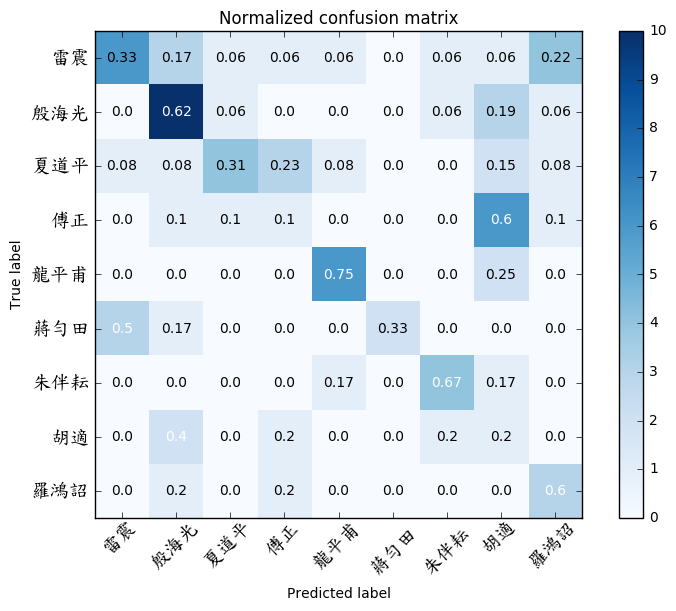

In [7]:
#輸出介面
feature_file_path = paper_feature_path
feature_file_name = '自由中國前100個N+N.csv'

test_size = 0.2
kernel = 'RF' #RF/SVM
threshold = 0.5

X_raw,y_raw = article_get(condicate_author_path)
feature = feature_select(feature_file_path+feature_file_name)
X = article_vector(X_raw,feature,feature_file_name)
y = np.array(y_raw)

#X,y = random_balance(X,y)

model,y_true,y_pred = predict_model(X,y,test_size,kernel)

predict_report(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average=None)
print ('F1預測閥值：',threshold)
fit_class = [(i,e) for i,e in enumerate(f1) if e > threshold]
print ('可預測： '+' '.join([str(classification_name[x])+':'+str(round(y,2)) 
                         for x,y in fit_class]))

predict_confusion_matrix(y_true, y_pred, True)
set_tree_path(model)

In [12]:
#觀察類別路徑規則
pre = 'C:\\Users\\user\\Desktop\\author_path\\'

classification_path = defaultdict(list)

#找出各路徑規則
for i,e in fit_class:
    name = classification_name[i]
    with codecs.open(pre+name+'.txt','rb','utf8') as f:
        #print (name)
        num = ''
        for line in f.readlines():
            line = line.strip()
            
            if line == '':
                continue
            elif line[0] == '#':
                num = line[1:]
                continue
            
            element_temp = line.split(':')[0].split(' & ')

            element = {}

            for j in element_temp: #重複清理
                j = j.split()
                if (j[0],j[1]) not in element:
                    element[(j[0],j[1])] = j[2]
                else:
                    if j[1] == '<=':
                        element[(j[0],j[1])] = str(min(float(j[2]),float(element[(j[0],j[1])])))
                    elif j[1] == '>':
                        element[(j[0],j[1])] = str(max(float(j[2]),float(element[(j[0],j[1])])))
                    else:
                        print ('ERROR')

            element = [k[0]+' '+k[1]+' '+v for k,v in element.items()]
            element.insert(0,num)
            classification_path[name].append(element)

classification_rule = defaultdict(dict)

#建立兩兩規則
for i in classification_path:
    for j in classification_path[i]:
        comb = [i for i in itertools.combinations(j[1:],2)]
        for k in comb:
            if k[0] > k[1]: #避免有著順序不同的key
                k = (k[1],k[0])
            if k not in classification_rule[i]:
                classification_rule[i][k] = float(j[0])
            else:
                classification_rule[i][k] += float(j[0])
                
        if len(comb) == 0:
            classification_rule[i][(j[1],)] = float(j[0])
        
#印出
for i in classification_rule:
    print (i)
    so = sorted(classification_rule[i].items(), key=lambda d:d[1], reverse = True)
    index = 0
    for x,y in so:
        index += 1
        if index == 20:
            break
        print (x,y)
    print ()
    
    ee = defaultdict(str)
    index = 1
    with codecs.open('C:\\Users\\user\\Desktop\\node.txt','wb','utf8') as g:
        g.write('id\tcombine\r\n')
        for k,v in classification_rule[i].items():
            if k[0] not in ee:
                ee[k[0]] = index
                g.write(str(index)+'\t'+k[0]+'\r\n')
                index += 1
            if len(k) > 1 and k[1] not in ee:
                ee[k[1]] = index
                g.write(str(index)+'\t'+k[1]+'\r\n')
                index += 1
        g.write(str(index)+'\tX\r\n')
                
    with codecs.open('C:\\Users\\user\\Desktop\\link.txt','wb','utf8') as g:
        g.write('source\ttarget\ttype\tweight\r\n')
        for x,y in so:
            if len(x) < 2:
                g.write(str(ee[x[0]])+'\t'+str(index)+'\tUndirected\t'+str(y)+'\r\n')
            else:
                g.write(str(ee[x[0]])+'\t'+str(ee[x[1]])+'\tUndirected\t'+str(y)+'\r\n')
    
    break

殷海光
('一段(Nc)話(Na) <= 191.5', '國際(Nc)局勢(Na) <= 62.0') 402.0
('中山(Nb)先生(Na) <= 85.0', '國際(Nc)局勢(Na) <= 62.0') 391.0
('公約(Na)組織(Na) <= 59.0', '民意(Na)機關(Na) <= 45.5') 302.0
('國際(Nc)局勢(Na) <= 62.0', '政府(Na)當局(Na) <= 82.5') 296.0
('司法(Na)機關(Na) <= 71.0', '國際(Nc)局勢(Na) <= 62.0') 283.0
('國際(Nc)局勢(Na) <= 62.0', '民意(Na)機關(Na) <= 45.5') 283.0
('北大西洋(Nc)公約(Na) <= 59.5', '國際(Nc)局勢(Na) <= 62.0') 277.0
('公約(Na)組織(Na) <= 59.0', '國際(Nc)局勢(Na) <= 62.0') 250.0
('內閣(Na)總理(Na) <= 113.5', '民意(Na)機關(Na) <= 45.5') 250.0
('中山(Nb)先生(Na) <= 85.0', '日本(Nc)政府(Na) <= 50.5') 243.0
('國際(Nc)局勢(Na) <= 62.0', '民主(Na)國家(Na) <= 29.0') 242.0
('一段(Nc)話(Na) <= 191.5', '民意(Na)機關(Na) <= 45.5') 235.0
('國際(Nc)局勢(Na) <= 62.0', '組(Nc)黨(Na) <= 168.0') 234.0
('一段(Nc)話(Na) <= 191.5', '公約(Na)組織(Na) <= 59.0') 234.0
('國際(Nc)局勢(Na) <= 62.0', '外交(Na)政策(Na) <= 58.5') 222.0
('國際(Nc)局勢(Na) <= 62.0', '知識(Na)份子(Na) <= 455.0') 209.0
('中山(Nb)先生(Na) <= 85.0', '自由(Na)世界(Nc) <= 59.0') 204.0
('國民(Na)政府(Na) <= 37.5', '國際(Nc)局勢(Na) <= 62.0') 204.0
('民